In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [3]:
# data
X = np.array([1, 2, 3, 4, 5])
y = np.array([1, 3, 3, 3, 5])
x_bar = np.mean(X)  # for mean centering

with pm.Model() as m:  # context manager with pm.Model class
    # priors
    alpha = pm.Normal("alpha", sigma=100)
    beta = pm.Normal("beta", sigma=100)
    # using the professor's standard precision prior
    tau = pm.Gamma("tau", alpha=0.001, beta=0.001)

    # what if we want to know sigma (std. dev.)?
    sigma = pm.Deterministic("sigma", 1 / (tau**0.5))

    mu = alpha + beta * (X - x_bar)

    # likelihood uses observed parameter to incorporate target data
    # the Normal dist can be specified either tau (precision) or sigma (stdev)
    pm.Normal("likelihood", mu=mu, tau=tau, observed=y)

    # start sampling and save results to trace variable
    trace = pm.sample(
        draws=3000,
        # chains=4,  # independent runs of the sampling process, for diagnostics
        # tune=500, # tuning sampler hyperparameters (these values are burned)
        # init="jitter+adapt_diag",  # method for choosing initial values
        # random_seed=1,
        # cores=4,  # parallel processing of chains
        # nuts_sampler="nutpie", # try a different NUTS implementation
    )

Initializing NUTS using jitter+adapt_diag...
C:\Users\University\.conda\envs\pymc_env\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 22 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


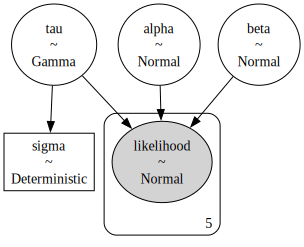

In [4]:
pm.model_to_graphviz(model=m)

In [6]:
# this burns the first 500 samples
trace_burned = trace.sel(draw=slice(500, None))

In [7]:
az.summary(trace_burned, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.989,0.552,2.039,4.027,0.010,0.041,4207.0,2637.0,1.0
beta,0.799,0.376,0.016,1.520,0.006,0.014,4724.0,3108.0,1.0
tau,1.866,1.557,0.018,4.969,0.033,0.038,1881.0,2123.0,1.0
sigma,1.012,0.694,0.348,2.167,0.018,0.062,1881.0,2115.0,1.0


In [8]:
az.hdi(trace_burned, hdi_prob=0.95)["beta"].values

array([0.01640259, 1.52020147])

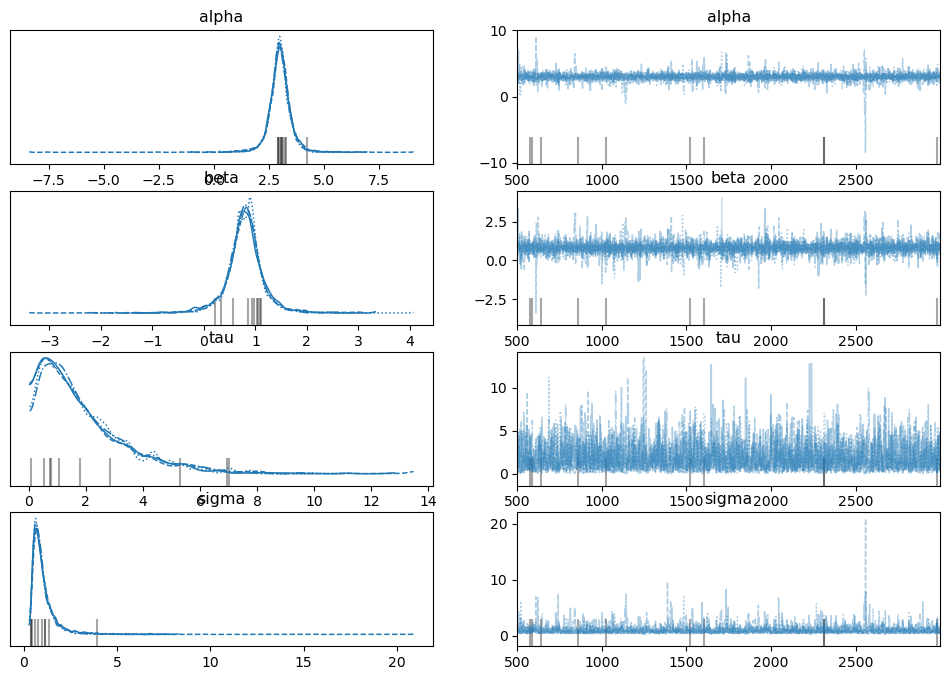

In [9]:
az.plot_trace(trace_burned)
plt.show()

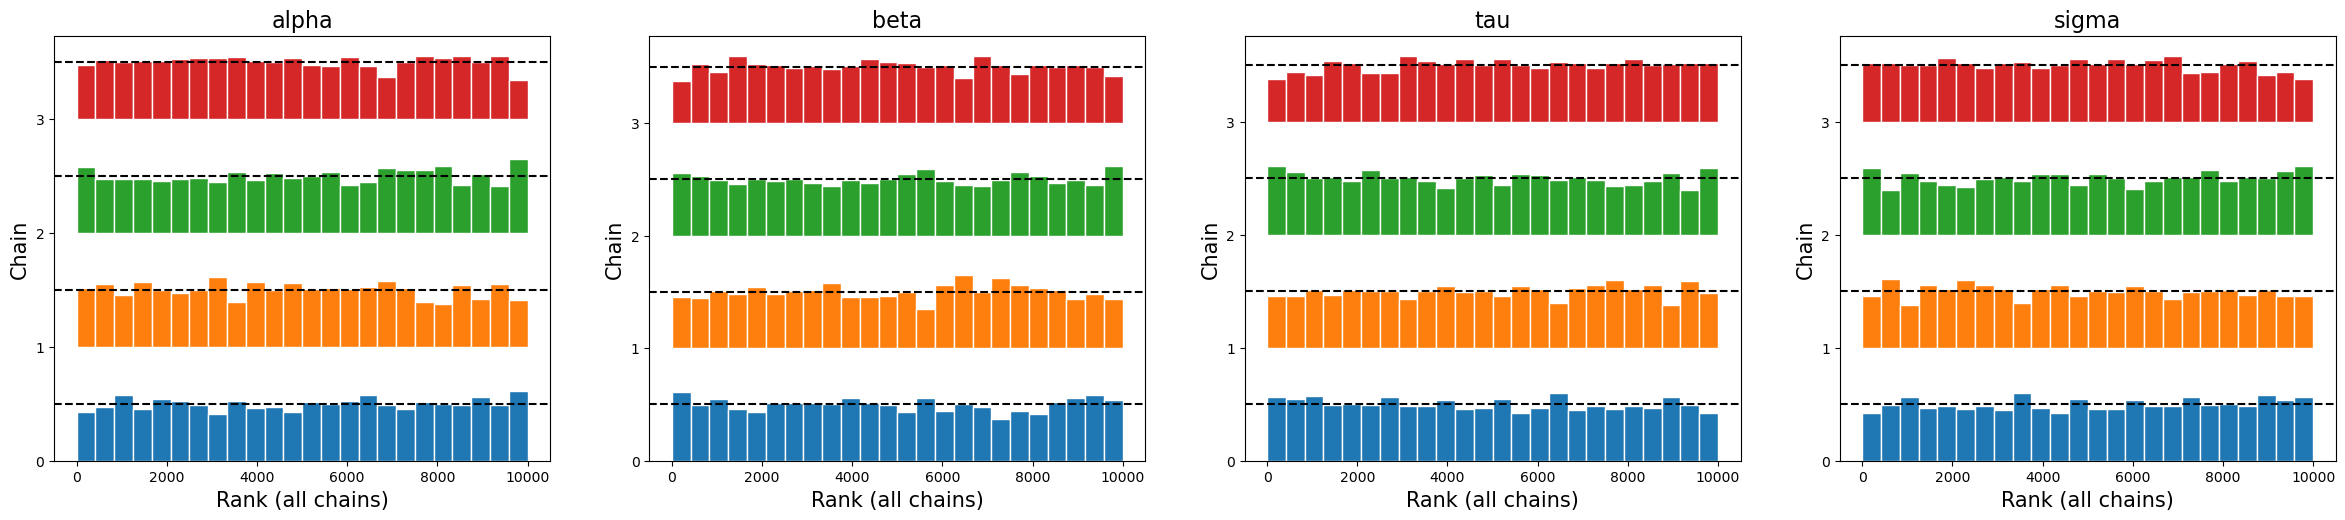

In [10]:
az.plot_rank(trace_burned)
plt.show()

In [11]:
# alpha - beta * x.bar
intercept = (
    trace_burned.posterior.alpha.mean()
    - trace_burned.posterior.beta.mean() * x_bar
)
intercept.values

array(0.59116578)